In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from models import UNET
from monai.networks.nets import UNet
import torch
from thop import profile
import torch.nn as nn
import torch.nn.functional as F
import time


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
import sys  
sys.path.insert(1, r'/home/alex/Documents/new try/Code/Studie_daten')
from models_2 import KeypointModel, EfficentNet

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
model_names = []
param_counts = []
flop_counts = []
evaluation_times = []

In [5]:
Monai_unet = UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128),
        strides=(2,2,2),
        num_res_units=0
).to(DEVICE)

input = torch.randn(1, 1, 256, 256).to(DEVICE)

# Berechnung der FLOPs und Parameter
flops, params = profile(Monai_unet, inputs=(input,))
model_names.append('Monai Unet')
param_counts.append(params)
flop_counts.append(flops)

Monai_unet.eval()
start_time = time.time()
with torch.no_grad():
    output = Monai_unet(input)
end_time = time.time()

# Calculate and print the evaluation time
evaluation_times.append(round(end_time - start_time,4))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.instancenorm.InstanceNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_prelu() for <class 'torch.nn.modules.activation.PReLU'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.


/home/alex/.local/lib/python3.10/site-packages/thop/vision/calc_func.py:53: UserWarning: This API is being deprecated
  warnings.warn("This API is being deprecated")


In [6]:
Keypoint_model = KeypointModel().to(DEVICE)

input = torch.randn(1,1,256,256).to(DEVICE)

flops, params = profile(Keypoint_model, inputs=(input,))
model_names.append('Keypoint detection')
param_counts.append(params)
flop_counts.append(flops)

Keypoint_model.eval()
start_time = time.time()
with torch.no_grad():
    output = Keypoint_model(input)
end_time = time.time()

# Calculate and print the evaluation time
evaluation_times.append(round(end_time - start_time,4))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


In [7]:
Own_unet = UNET(
    in_channels=1, 
    out_channels=1, 
    features= [16, 32, 64, 128]).to(DEVICE)

input = torch.randn(1, 1, 256, 256).to(DEVICE)

# Berechnung der FLOPs und Parameter
flops, params = profile(Own_unet, inputs=(input,))
model_names.append('Own Unet')
param_counts.append(params)
flop_counts.append(flops)

Own_unet.eval()
start_time = time.time()
with torch.no_grad():
    output = Own_unet(input)
end_time = time.time()

# Calculate and print the evaluation time
evaluation_times.append(round(end_time - start_time,4))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.


In [8]:
EfficentNet = EfficentNet().to(DEVICE)

input = torch.randn(1, 3, 256, 256).to(DEVICE)

# Berechnung der FLOPs und Parameter
flops, params = profile(EfficentNet, inputs=(input,))
model_names.append('EfficentNet')
param_counts.append(params)
flop_counts.append(flops)

EfficentNet.eval()
start_time = time.time()
with torch.no_grad():
    output = EfficentNet(input)
end_time = time.time()

# Calculate and print the evaluation time
evaluation_times.append(round(end_time - start_time,4))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


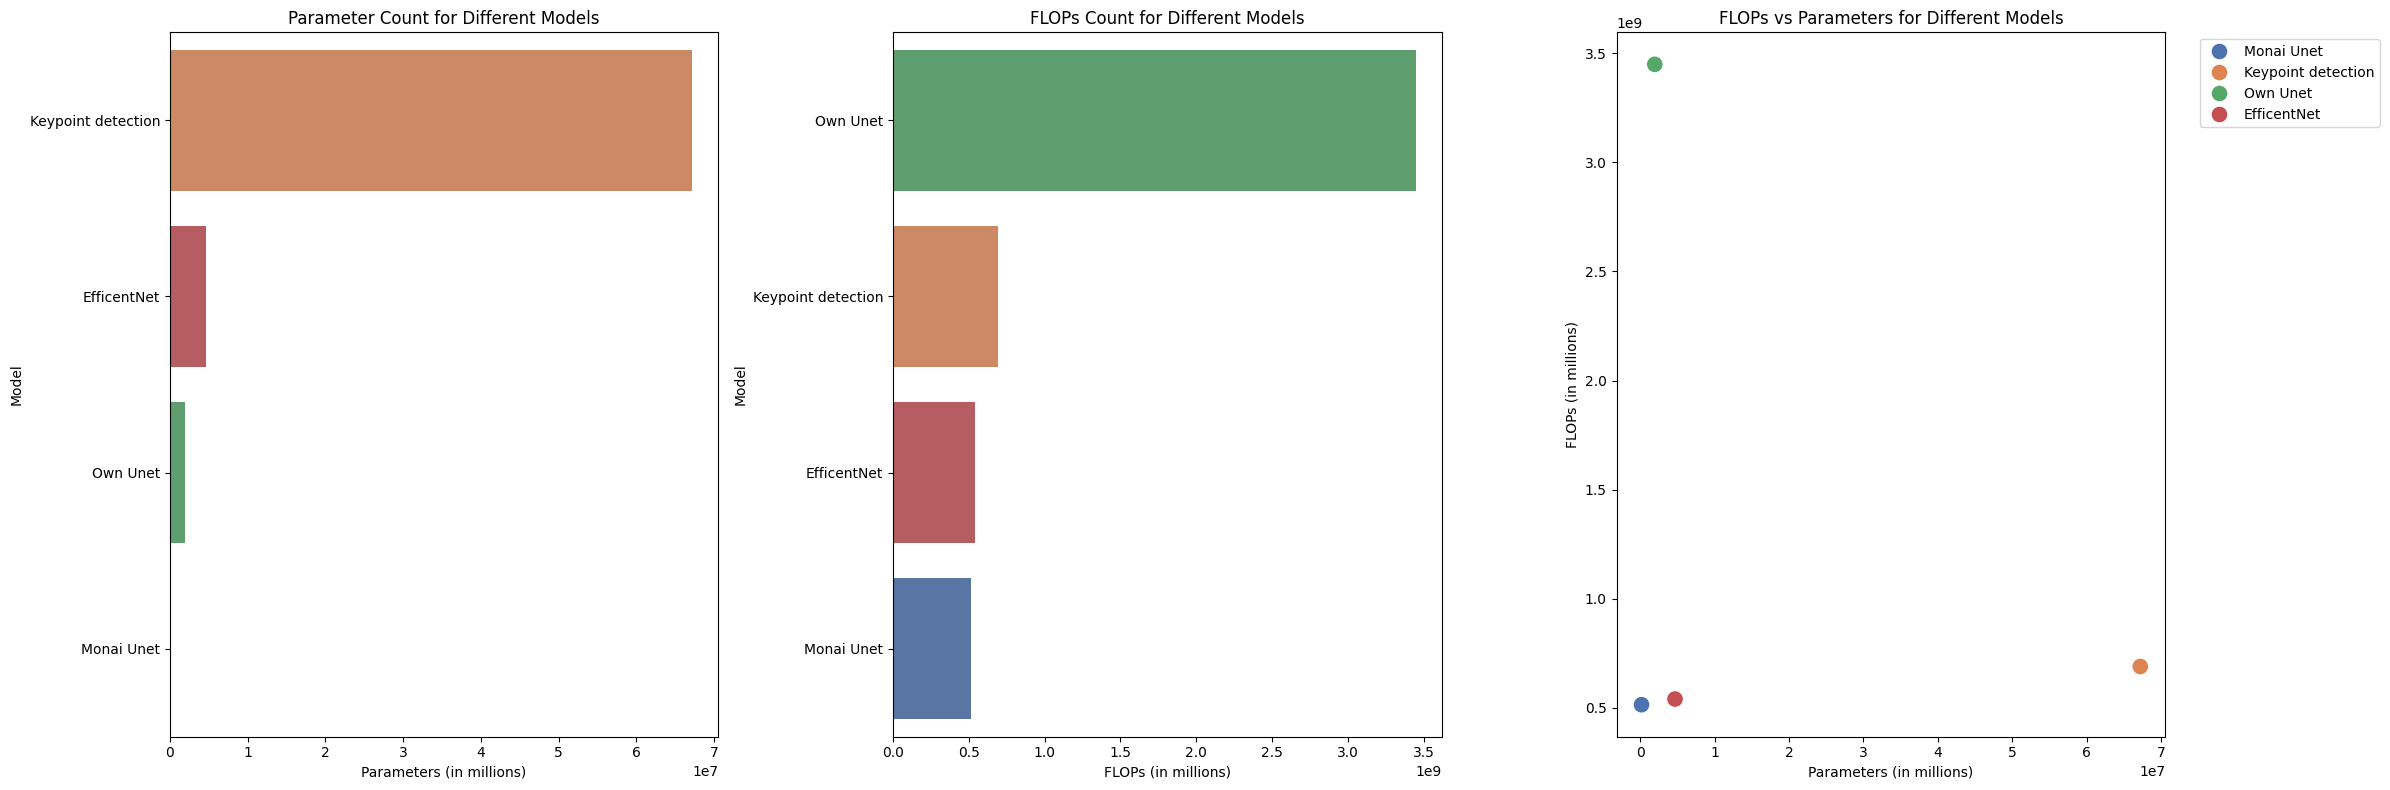

In [9]:
# Daten in ein DataFrame umwandeln
data = pd.DataFrame({
    'Model': model_names,
    'Parameters (M)': param_counts,
    'FLOPs (M)': flop_counts
})

# Sortiere die Daten nach der Anzahl der Parameter
data_sorted_by_params = data.sort_values(by='Parameters (M)', ascending=False)
data_sorted_by_flops = data.sort_values(by='FLOPs (M)', ascending=False)


categories = data["Model"].unique()
palette = sns.color_palette("deep", len(categories))

# Create a dictionary to map each category to a specific color
color_mapping = dict(zip(categories, palette))


# Erstellen der Subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Barplot für Parameter
sns.barplot(x='Parameters (M)', y='Model', data=data_sorted_by_params, hue = 'Model', palette=color_mapping, ax=axes[0])
axes[0].set_title('Parameter Count for Different Models')
axes[0].set_xlabel('Parameters (in millions)')
axes[0].set_ylabel('Model')

# Barplot für FLOPs
sns.barplot(x='FLOPs (M)', y='Model', data=data_sorted_by_flops, hue = 'Model', palette=color_mapping, ax=axes[1])
axes[1].set_title('FLOPs Count for Different Models')
axes[1].set_xlabel('FLOPs (in millions)')
axes[1].set_ylabel('Model')

# Scatterplot für FLOPs vs Parameters
sns.scatterplot(x='Parameters (M)', y='FLOPs (M)', hue='Model', data=data, palette=color_mapping, s=150, ax=axes[2])
axes[2].set_title('FLOPs vs Parameters for Different Models')
axes[2].set_xlabel('Parameters (in millions)')
axes[2].set_ylabel('FLOPs (in millions)')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Layout-Anpassungen
plt.tight_layout()
plt.show()

In [10]:
data

,Model,Parameters (M),FLOPs (M)
0,Monai Unet,162007.0,5.149164e+08
1,Keypoint detection,67206152.0,6.899671e+08
2,Own Unet,1942289.0,3.448242e+09
3,EfficentNet,4662916.0,5.409354e+08


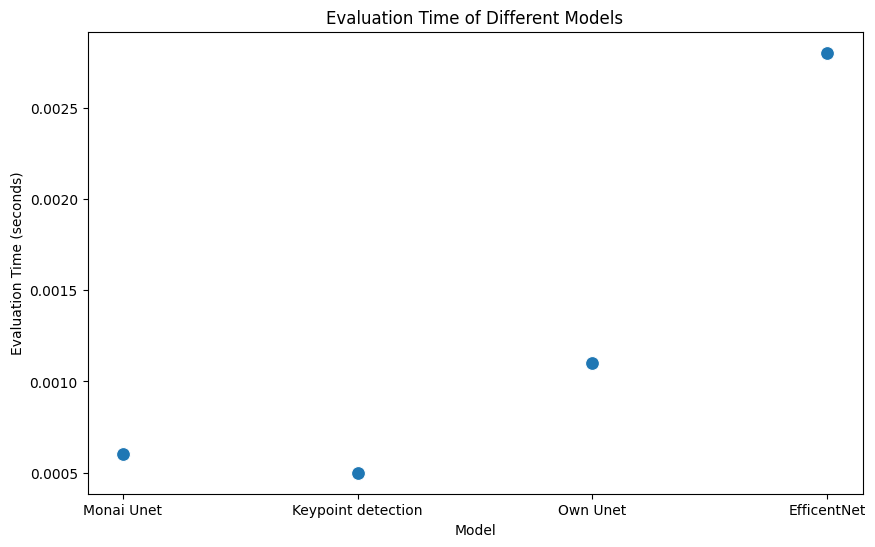

In [11]:
data = pd.DataFrame({
    'Model': model_names,
    'Evaluation time (s)': evaluation_times
})

# Create a DataFrame from the data
df = pd.DataFrame(data)


plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Model', y='Evaluation time (s)', s=100)

# Add title and labels
plt.title('Evaluation Time of Different Models')
plt.xlabel('Model')
plt.ylabel('Evaluation Time (seconds)')

# Show the plot
plt.show()

In [12]:
data

,Model,Evaluation time (s)
0,Monai Unet,0.0006
1,Keypoint detection,0.0005
2,Own Unet,0.0011
3,EfficentNet,0.0028
